# MLP


#### OK, here we will introduce a slightly more advanced model for MakeMore.

#### The baseline paper is: "A Neural Probabilistic Language Model", by Y. Bengio, et al., JMLR 2003 (https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


#### As before, we load the name file.


In [1]:
words = open("names.txt", "r").read().splitlines()


#### ..and create encoding / decoding maps.


In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### Our new model will be more flexible - N-gram, where any N is acceptable. We call it block size, as Andrej noted.


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

#### If the block size is 3, the fourth character is predicted given the previous three charactors ("context")

#### For example, for the name "emma", the following datasets are defined for X and Y.


In [4]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)
X, Y = [], []
for w in words[:1]:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]  # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)


... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


#### OK, now we will need to implement the network structure.

#### The key idea of the paper is to represent the embeded context by a set of numerical vectors.

#### This might be confusing at a first glance, so let's take a look at an example.


In [5]:
g = torch.Generator().manual_seed(2023)


#### For "emma", the X data is (5-by-3) matrix.


In [6]:
X


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

#### Suppose, we would like to map this into 2 dimensional space.


In [7]:
C = torch.randn((27, 2), generator=g)


#### What is this C??

#### C is a mapping from a character to a 2D-vector. See below.


In [8]:
for i in range(C.shape[0]):
    print(f"'{itos[i]}' = {i} ---> {C[i].numpy()}")


'.' = 0 ---> [ 0.43047658 -0.34990272]
'a' = 1 ---> [0.47494158 0.9040745 ]
'b' = 2 ---> [-0.7021243  1.5963098]
'c' = 3 ---> [ 0.42280173 -0.6939658 ]
'd' = 4 ---> [0.9671831 1.5569055]
'e' = 5 ---> [-2.3860264   0.69941294]
'f' = 6 ---> [-1.0325073 -2.6042871]
'g' = 7 ---> [ 0.93368316 -0.104961  ]
'h' = 8 ---> [ 0.7426688 -1.3397279]
'i' = 9 ---> [-0.36485666  0.25399405]
'j' = 10 ---> [-1.4082499  0.2834718]
'k' = 11 ---> [-0.9333327 -0.6278479]
'l' = 12 ---> [-0.07515199 -2.2086177 ]
'm' = 13 ---> [-1.1255676   0.02481801]
'n' = 14 ---> [ 1.2566363 -0.936987 ]
'o' = 15 ---> [0.04863797 0.28411   ]
'p' = 16 ---> [-0.9557821  1.4745294]
'q' = 17 ---> [ 0.5108632  -0.23249477]
'r' = 18 ---> [0.39578572 0.85356665]
's' = 19 ---> [-0.22113085 -1.6946394 ]
't' = 20 ---> [0.07243163 0.68232703]
'u' = 21 ---> [-0.3922678  2.6640363]
'v' = 22 ---> [-1.2798094   0.45365483]
'w' = 23 ---> [0.5053759 1.8711396]
'x' = 24 ---> [-2.1565547 -1.0950136]
'y' = 25 ---> [-0.5773067 -0.6386164]
'z' = 

#### Using pytorch's smart(?) tensor operation ability, the representation of X by C is: `C[X]`


In [9]:
C[X]


tensor([[[ 0.4305, -0.3499],
         [ 0.4305, -0.3499],
         [ 0.4305, -0.3499]],

        [[ 0.4305, -0.3499],
         [ 0.4305, -0.3499],
         [-2.3860,  0.6994]],

        [[ 0.4305, -0.3499],
         [-2.3860,  0.6994],
         [-1.1256,  0.0248]],

        [[-2.3860,  0.6994],
         [-1.1256,  0.0248],
         [-1.1256,  0.0248]],

        [[-1.1256,  0.0248],
         [-1.1256,  0.0248],
         [ 0.4749,  0.9041]]])

#### or, if we reshape it,


In [10]:
C[X].view((5, 6))


tensor([[ 0.4305, -0.3499,  0.4305, -0.3499,  0.4305, -0.3499],
        [ 0.4305, -0.3499,  0.4305, -0.3499, -2.3860,  0.6994],
        [ 0.4305, -0.3499, -2.3860,  0.6994, -1.1256,  0.0248],
        [-2.3860,  0.6994, -1.1256,  0.0248, -1.1256,  0.0248],
        [-1.1256,  0.0248, -1.1256,  0.0248,  0.4749,  0.9041]])

#### To make it clear, compare this with X.


In [11]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)
context = [0] * block_size
for i, ch in enumerate(w + "."):
    ix = stoi[ch]
    print(
        f"'{''.join(itos[i] for i in context)}' = {X[i].numpy()} --> {C[X].view((5,6))[i].numpy()}"
    )
    context = context[1:] + [ix]  # crop and append


'...' = [0 0 0] --> [ 0.43047658 -0.34990272  0.43047658 -0.34990272  0.43047658 -0.34990272]
'..e' = [0 0 5] --> [ 0.43047658 -0.34990272  0.43047658 -0.34990272 -2.3860264   0.69941294]
'.em' = [ 0  5 13] --> [ 0.43047658 -0.34990272 -2.3860264   0.69941294 -1.1255676   0.02481801]
'emm' = [ 5 13 13] --> [-2.3860264   0.69941294 -1.1255676   0.02481801 -1.1255676   0.02481801]
'mma' = [13 13  1] --> [-1.1255676   0.02481801 -1.1255676   0.02481801  0.47494158  0.9040745 ]


#### Much clearer now. Let's move on.


#### We implement network architecture: y*pred = W2 * tanh (W1 \_ emb(X) + b1) + b2.


#### First, we split train / validation / test using the entire data. We will use `block_size = 4`.


In [12]:
block_size = 4


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])


In [13]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)


((torch.Size([182625, 4]), torch.Size([182625])),
 (torch.Size([22655, 4]), torch.Size([22655])),
 (torch.Size([22866, 4]), torch.Size([22866])))

#### Let's set some parameters.


In [14]:
n_hidden = 100  # number of neurons
n_embd = 10  # representation dimension
n_chars = 27  # number of characters


#### The following parameters are initialized.


In [15]:
C = torch.randn((n_chars, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, n_chars), generator=g)
b2 = torch.randn(n_chars, generator=g) * 0
parameters = [C, W1, b1, W2, b2]


#### Note that in his lecture, Andrej talked about initialization and batch normailization, which turns out to be pretty critical in terms of understanding as well as model performance.

#### So we will examine them here.


#### First, we would like to suppress W2 and b2, since they are unnecessarily too big initially.


In [16]:
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01
b2 = torch.randn(n_chars, generator=g) * 0


#### Second, in `tanh` neuron, if its output is close to 1, it will be in very flat region.

#### So then the changing in the input does not affect it -> no backward gradient.


#### For example, if the initialized activation function has too extreme.


In [17]:
ix = torch.randint(0, x_train.shape[0], (32,))
hpreact = C[x_train[ix]].view((-1, n_embd * block_size)) @ W1 + b1
h = torch.tanh(hpreact)


(array([1291.,   62.,   39.,   35.,   23.,   14.,   25.,   14.,   15.,
          12.,   11.,   14.,   10.,    8.,    7.,    4.,   14.,   12.,
           8.,   16.,    5.,    9.,    9.,    7.,   10.,    7.,    5.,
          13.,    5.,    9.,   10.,    6.,   11.,    8.,    7.,    9.,
           6.,    9.,   14.,   14.,   16.,   16.,   26.,   24.,   26.,
          24.,   29.,   53.,   71., 1108.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

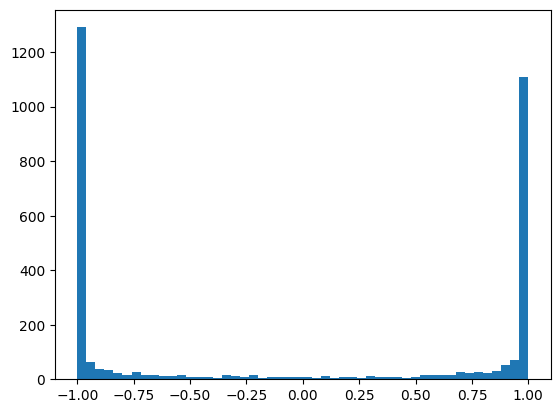

In [18]:
plt.hist(h.view(-1).tolist(), 50)


#### So a modification would be to suppress `W1` and `b1`.


In [19]:
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01


#### ..which gives us much reasonable ranges for the initial activation:


(array([11., 17., 28., 42., 50., 45., 57., 57., 74., 62., 58., 76., 68.,
        69., 74., 81., 73., 73., 76., 74., 90., 74., 85., 74., 80., 78.,
        97., 83., 68., 62., 62., 91., 83., 74., 77., 83., 55., 72., 89.,
        69., 59., 70., 50., 56., 75., 61., 43., 36., 25., 14.]),
 array([-0.98373568, -0.94490332, -0.90607095, -0.86723858, -0.82840622,
        -0.78957385, -0.75074149, -0.71190912, -0.67307676, -0.63424439,
        -0.59541203, -0.55657966, -0.5177473 , -0.47891493, -0.44008257,
        -0.4012502 , -0.36241784, -0.32358547, -0.28475311, -0.24592074,
        -0.20708838, -0.16825601, -0.12942364, -0.09059128, -0.05175891,
        -0.01292655,  0.02590582,  0.06473818,  0.10357055,  0.14240291,
         0.18123528,  0.22006764,  0.25890001,  0.29773237,  0.33656474,
         0.3753971 ,  0.41422947,  0.45306183,  0.4918942 ,  0.53072657,
         0.56955893,  0.6083913 ,  0.64722366,  0.68605603,  0.72488839,
         0.76372076,  0.80255312,  0.84138549,  0.88021785,

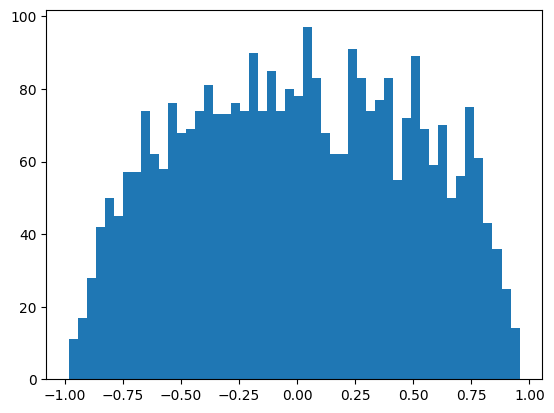

In [20]:
hpreact = C[x_train[ix]].view((-1, n_embd * block_size)) @ W1 + b1
h = torch.tanh(hpreact)
plt.hist(h.view(-1).tolist(), 50)


#### On the other hand, there is a well-known method for initialization.

#### From https://pytorch.org/docs/stable/nn.init.html

#### The standard deviation for the resulting tensor is: `gain / (sqrt (fan_mode))`, where `gain=5/3` for `tanh` and `fan_mode=n_embd * block_size` in our case.


#### Thus, the revised initialization becomes:


In [21]:
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.01


#### Another aspect we need to consider is batch normalization.


#### For each batch, we want to standardize it and want it to move dynamically.


In [22]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
hpreact = C[x_train[ix]].view((-1, n_embd * block_size)) @ W1 + b1
hpreact = (
    bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    + bnbias
)
h = torch.tanh(hpreact)


#### Ok, now, let's rewrite the initilization and implement the training process with the batch normalization.


#### Intialization


In [23]:
g = torch.Generator().manual_seed(42)
C = torch.randn((n_chars, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01
b2 = torch.randn(n_chars, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]


#### We requires gradients for all parameters.

In [24]:
for p in parameters:
    p.requires_grad = True

#### OK, let's run the training a few steps.


In [25]:
list_loss_train_batch = []
batch_size = 32
for i in range(10000):
    ix = torch.randint(0, x_train.shape[0], (batch_size,))
    X_enc = C[x_train[ix]]
    X_enc_concat = X_enc.view((-1, n_embd * block_size))
    hpreact = X_enc_concat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])
    alpha = 0.999
    with torch.no_grad():
        bnmean_running = alpha * bnmean_running + (1.0 - alpha) * bnmeani
        bnstd_running = alpha * bnstd_running + (1.0 - alpha) * bnstdi
    for p in parameters:
        p.grad = None
    loss.backward()
    if (i + 1) % 1000 == 0:
        print(i + 1, loss.item())
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad
    list_loss_train_batch.append(loss.item())


1000 2.434471368789673
2000 2.2259421348571777
3000 2.0657782554626465
4000 2.3571791648864746
5000 2.344364643096924
6000 2.417529344558716
7000 2.000009059906006
8000 1.9659472703933716
9000 2.2283077239990234
10000 2.3422837257385254


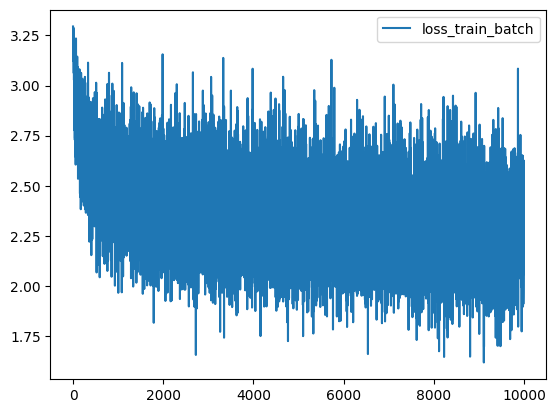

In [28]:
import pandas as pd

ax = pd.DataFrame(
    {"loss_train_batch": list_loss_train_batch}, index=range(len(list_loss_train_batch))
).plot()


#### So the training up to 10000 steps is done. Although it is not enough training, let's just see what it gives us.


In [29]:
# sample from the model
g = torch.Generator().manual_seed(42)
for _ in range(10):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))


mavsyahllingh.
dllekhim.
marrys.
tryvin.
chwksenn.
dlpprjikh.
hzkellanashandy.
javudh.
prpollnndz.
jlorannllumhanna.


#### Definitely, the training is happening, but we want more training with probably more complex architecture (for better results)


#### How much more training is needed? 
#### We don't know. We actuall need more care to have better controls.


#### First of all,the codes can be cleaned.


#### In his lecture, Andrej provides the following "PyTorch-fied" codes.


#### The first one Linear filter (which is very similar to `torch.nn.Linear` (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html))


In [30]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


#### Next, `BatchNorm1d` class is for batch normalization. Nothing is new, except some variable names.


In [31]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta  # This is for diagnosis.

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


#### We also need `Tanh`. Note that there is no parameter needed.


In [32]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


#### Here is the initialization stage. The `layers` is the list of `Linear` and `Tanh`. `Tanh` layers are needed to incorporate non-linearity and higher representation power. We skip `BatchNorm1d` for now but will add it later.


In [33]:
n_embd = 10  # the dimension of character embedding vectors
n_hidden = 100  # the number of neurons in hidden layer of the MLP
g = torch.Generator().manual_seed(42)

C = torch.randn((n_chars, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_chars, bias=False),
    BatchNorm1d(n_chars),
]


#### As we discussed above, we suppress the initial parameters, and pre-apply the gain from Tanh.


In [34]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3


#### There are 47024 parameters.


In [36]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))  # number of parameters in total
for p in parameters:
    p.requires_grad = True


47024


#### Here is the final version of Code for training. Let's run one step, and how the networks look like.


In [37]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[x_train[ix]]
    x = emb.view((emb.shape[0], -1))
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_train[ix])

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )
    break
    # if i > 50000:
    #     break


      0/ 200000: 3.3038


#### Andrej also provides a toolkit to diagnose how the networks behave during the training.


In [38]:
@torch.no_grad()
def diagnose_network(layers):
    # visualize histograms
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i, ax in enumerate(
        axes.reshape(
            2,
        )
    ):
        if i == 0:
            legends = []
            for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
                if isinstance(layer, Tanh):
                    t = layer.out
                    print(
                        "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
                        % (
                            i,
                            layer.__class__.__name__,
                            t.mean(),
                            t.std(),
                            (t.abs() > 0.97).float().mean() * 100,
                        )
                    )
                    hy, hx = torch.histogram(t, density=True)
                    ax.plot(hx[:-1].detach(), hy.detach())
                    legends.append(f"layer {i} ({layer.__class__.__name__})")
            ax.legend(legends)
            ax.set_title("activation distribution")
        if i == 1:
            legends = []
            for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
                if isinstance(layer, Tanh):
                    t = layer.out.grad
                    print(
                        "layer %d (%10s): mean %+f, std %e"
                        % (i, layer.__class__.__name__, t.mean(), t.std())
                    )
                    hy, hx = torch.histogram(t, density=True)
                    ax.plot(hx[:-1].detach(), hy.detach())
                    legends.append(f"layer {i} ({layer.__class__.__name__})")
            ax.legend(legends)
            ax.set_title("gradient distribution")


layer 1 (      Tanh): mean +0.07, std 0.79, saturated: 29.53%
layer 3 (      Tanh): mean +0.02, std 0.68, saturated: 9.53%
layer 5 (      Tanh): mean -0.04, std 0.68, saturated: 7.28%
layer 7 (      Tanh): mean +0.04, std 0.66, saturated: 6.16%
layer 9 (      Tanh): mean +0.04, std 0.66, saturated: 4.97%
layer 1 (      Tanh): mean -0.000001, std 7.435333e-04
layer 3 (      Tanh): mean -0.000003, std 6.924099e-04
layer 5 (      Tanh): mean +0.000002, std 6.276588e-04
layer 7 (      Tanh): mean +0.000001, std 5.804013e-04
layer 9 (      Tanh): mean +0.000000, std 5.268731e-04


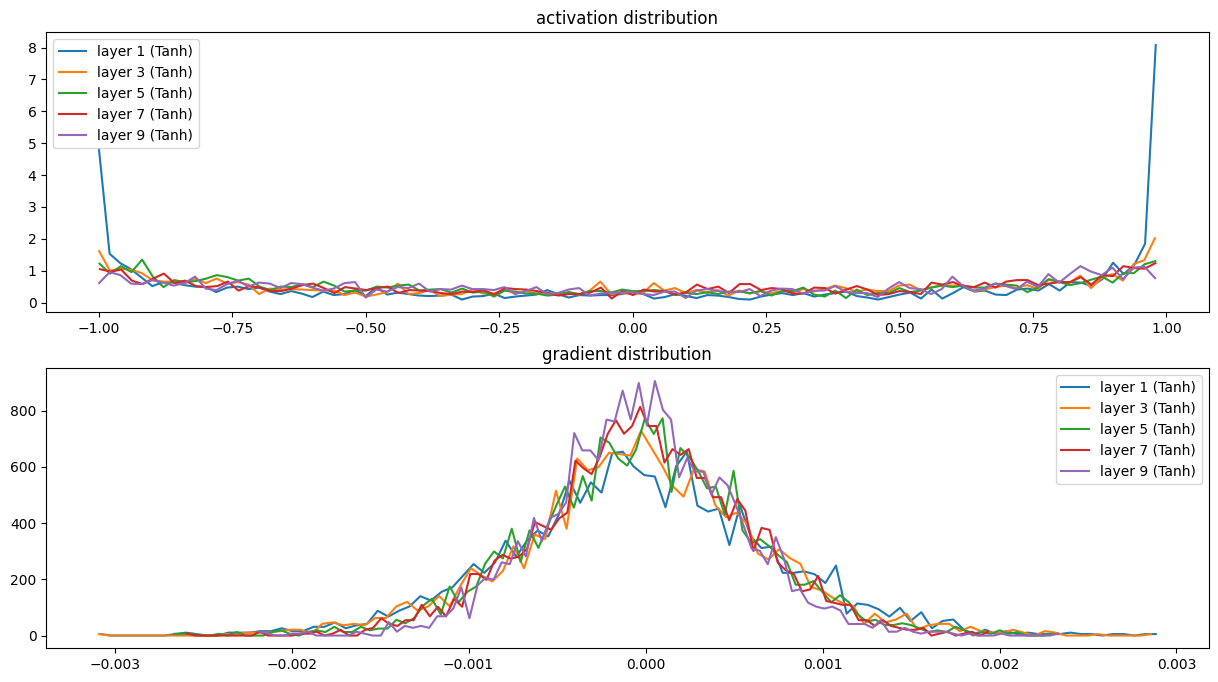

In [39]:
diagnose_network(layers)


#### The first layer is pretty "saturated", meaning many gradients are zero. Other layers are more stabalized, becaused of the gain factor 5/3.


#### Let's re-try it without the factor 5/3.


In [40]:
n_embd = 10  # the dimension of character embedding vectors
n_hidden = 200  # the number of neurons in hidden layer of the MLP
g = torch.Generator().manual_seed(42)

C = torch.randn((n_chars, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    # BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_chars, bias=False),
    BatchNorm1d(n_chars),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[x_train[ix]]
    x = emb.view((emb.shape[0], -1))
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_train[ix])

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )
    break
    # if i > 50000:
    #     break


173724
      0/ 200000: 3.3110


layer 1 (      Tanh): mean +0.03, std 0.66, saturated: 6.45%
layer 3 (      Tanh): mean +0.02, std 0.50, saturated: 0.25%
layer 5 (      Tanh): mean +0.01, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.36, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.31, saturated: 0.00%
layer 1 (      Tanh): mean -0.000005, std 4.808355e-04
layer 3 (      Tanh): mean +0.000003, std 5.979928e-04
layer 5 (      Tanh): mean +0.000003, std 6.929320e-04
layer 7 (      Tanh): mean +0.000001, std 8.178736e-04
layer 9 (      Tanh): mean +0.000000, std 8.817968e-04


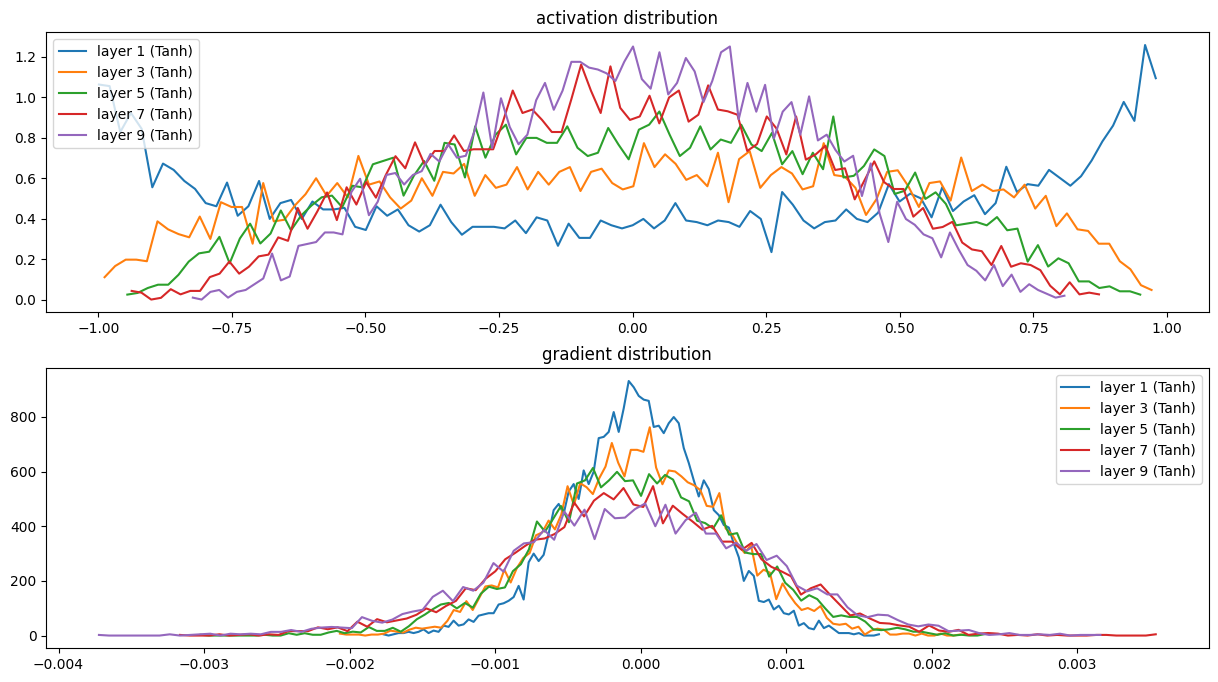

In [41]:
diagnose_network(layers)


#### As you see now here, the standard deviations are shrinking. This is because of the `tanh` layers, which squashes the distributions. Same things are happening for gradients. So some gains are necessary, which is why we added 5/3.


#### OK, we will bring 5/3 back and add `BatchNorm1d` layers, and see what would it look like after a single step of training.


In [42]:
n_embd = 10  # the dimension of character embedding vectors
n_hidden = 200  # the number of neurons in hidden layer of the MLP
g = torch.Generator().manual_seed(42)

C = torch.randn((n_chars, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_chars, bias=False),
    BatchNorm1d(n_chars),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[x_train[ix]]
    x = emb.view((emb.shape[0], -1))
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_train[ix])

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )
    break
    # if i > 50000:
    #     break


175724
      0/ 200000: 3.2924


layer 2 (      Tanh): mean +0.00, std 0.64, saturated: 2.42%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.61%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.70%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.44%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.81%
layer 2 (      Tanh): mean +0.000000, std 6.714886e-04
layer 5 (      Tanh): mean +0.000000, std 5.614284e-04
layer 8 (      Tanh): mean -0.000000, std 4.960757e-04
layer 11 (      Tanh): mean -0.000000, std 4.597152e-04
layer 14 (      Tanh): mean -0.000000, std 4.008338e-04


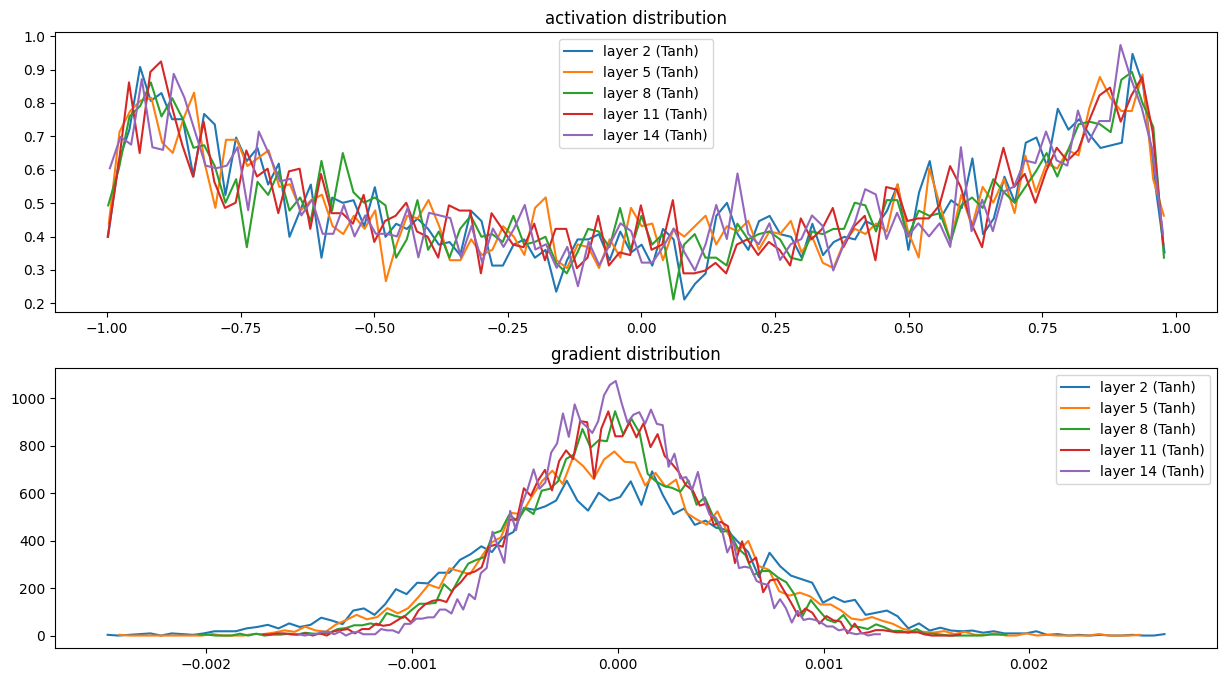

In [43]:
diagnose_network(layers)


#### Look, even after a single step, the values and gradients are much more homogenerous!


#### Finally, we have a final-final version (copy+paste of some of previous parts, but I wanted it to be a complete set).


In [44]:
block_size = 8
n_chars = 27
n_embd = 10  # the dimension of character embedding vectors
n_hidden = 200  # the number of neurons in hidden layer of the MLP
g = torch.Generator().manual_seed(42)
C = torch.randn((n_chars, n_embd), generator=g)


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_test, y_test = build_dataset(words[n2:])


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta  # This is for diagnosis.

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_chars, bias=False),
    BatchNorm1d(n_chars),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[x_train[ix]]
    x = emb.view((emb.shape[0], -1))
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_train[ix])

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

183724
      0/ 200000: 3.2866
  10000/ 200000: 2.1502
  20000/ 200000: 2.2104
  30000/ 200000: 1.8202
  40000/ 200000: 1.9523
  50000/ 200000: 1.8369
  60000/ 200000: 1.7947
  70000/ 200000: 1.9014
  80000/ 200000: 1.7291
  90000/ 200000: 1.7947
 100000/ 200000: 1.8325
 110000/ 200000: 2.2000
 120000/ 200000: 1.5369
 130000/ 200000: 2.0143
 140000/ 200000: 1.7852
 150000/ 200000: 1.9395
 160000/ 200000: 2.0482
 170000/ 200000: 1.6885
 180000/ 200000: 1.6284
 190000/ 200000: 1.6008


layer 2 (      Tanh): mean +0.01, std 0.71, saturated: 17.50%
layer 5 (      Tanh): mean +0.02, std 0.75, saturated: 21.28%
layer 8 (      Tanh): mean -0.01, std 0.77, saturated: 21.72%
layer 11 (      Tanh): mean -0.00, std 0.78, saturated: 22.14%
layer 14 (      Tanh): mean +0.00, std 0.78, saturated: 23.52%
layer 2 (      Tanh): mean +0.000000, std 3.790194e-03
layer 5 (      Tanh): mean -0.000000, std 3.474789e-03
layer 8 (      Tanh): mean +0.000000, std 3.296997e-03
layer 11 (      Tanh): mean -0.000000, std 2.762823e-03
layer 14 (      Tanh): mean -0.000000, std 2.877441e-03


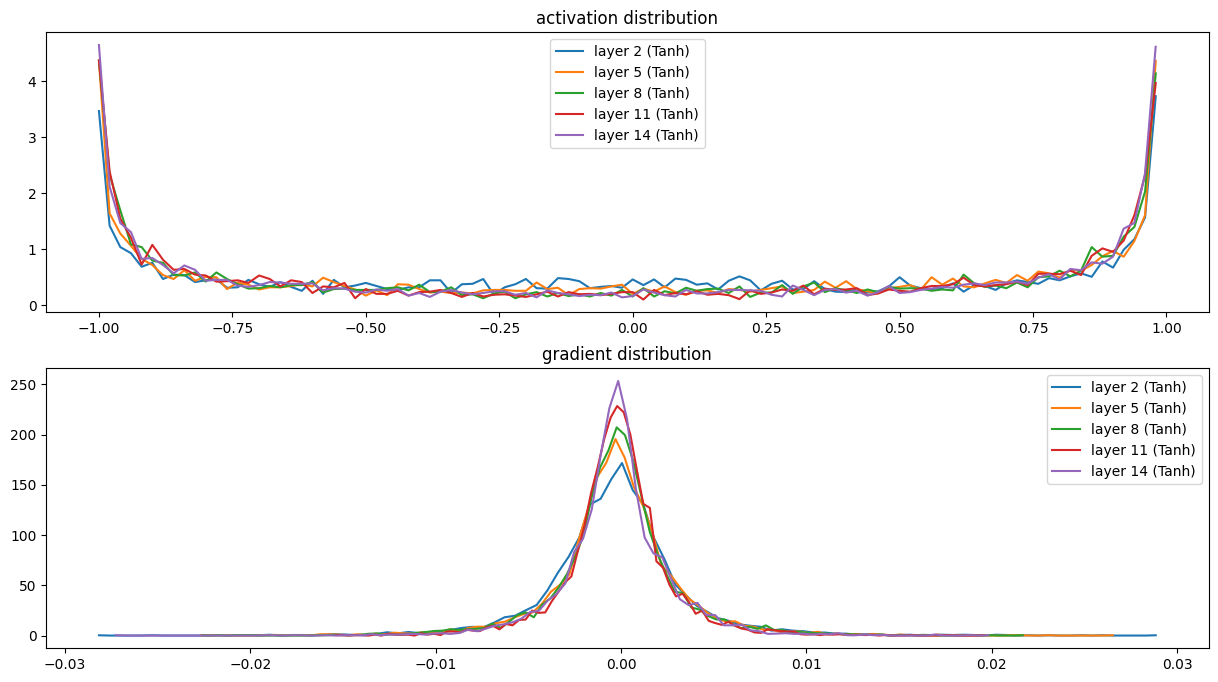

In [45]:
diagnose_network(layers) 

#### Here are the losses for training, validation, and test datasets (we update the loss calculation function, to incorporate multi-layers.)


In [46]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (x_train, y_train),
        "val": (x_val, y_val),
        "test": (x_test, y_test),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    x = emb.view((emb.shape[0], -1))  # concat into (N, block_size * n_embd)
    for layer in layers:
        if layer.__class__.__name__ == "BatchNorm1d":
            layer.training = False
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())


for d in ["train", "val", "test"]:
    split_loss(d)


train 1.6828173398971558
val 2.0029218196868896
test 2.001617193222046


In [47]:
# sample from the model
g = torch.Generator().manual_seed(42)
with torch.no_grad():
    for _ in range(10):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]
            x = emb.view(emb.shape[0], -1)
            for layer in layers:
                if layer.__class__.__name__ == "BatchNorm1d":
                    layer.training = False
                x = layer(x)
            logits = x
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            if ix == 0:
                break
            out.append(ix)

        print("".join(itos[i] for i in out))


yeesha
leilanni
camryn
maryda
trysten
hender
ellysoniah
abdijas
louanne
alivia


#### That's it.


#### In summary, in this notebook:

- We developed a MLP model for makemore, based on "A Neural Probabilistic Language Model", by Y. Bengio, et al., JMLR 2003 (https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).
- A batch normalization was introduced, which stabilize networks.
- Pytorch-fied modules are developed.
- A diagnostic tool for networks is developed, in order to look into what's happening inside.
